# Question 8: Is there a difference in the number of double faults based on gender?


In [3]:
import os
from pathlib import Path
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_day_folders(base_path):
    return sorted([
        folder for folder in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, folder)) and folder.startswith("2024")
    ])

def load_file_selected_columns(file, columns):
    try:
        return pd.read_parquet(file, columns=columns)
    except Exception as e:
        return None

def load_file_selected_columns(file, columns):
    try:

        df = pd.read_parquet(file)
        
        # Check which columns exist in the file
        existing_columns = [col for col in columns if col in df.columns]
        
        # If no required columns exist, skip this file
        if not existing_columns:
            return None
        
        # Select the existing columns and return the dataframe
        return df[existing_columns]
        
    except Exception as e:
        print(f"⚠️ Error reading {file}: {e}")
        return None

def load_all_data_selected_columns(base_path, subfolder_name, columns):
    all_files = []
    for folder in get_day_folders(base_path):
        path_pattern = Path(base_path) / folder / 'data' / 'raw' / subfolder_name
        all_files.extend(path_pattern.glob("*.parquet"))

    dfs = []
    failed_files = 0
    success_files = 0

    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(load_file_selected_columns, file, columns) for file in all_files]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading selected columns"):
            result = future.result()
            if result is not None:
                dfs.append(result)
                success_files += 1
            else:
                failed_files += 1

    print(f"✔️ Successfully loaded {success_files} files.")
    print(f"⚠️ Skipped {failed_files} files due to missing columns.")

    return pd.concat(dfs, ignore_index=True) if dfs else None

In [6]:
base_path = "../data/tennis_data"
required_stats_columns = ['match_id', 'statistic_name', 'home_value', 'away_value']
stats_df = load_all_data_selected_columns(base_path, 'raw_statistics_parquet', required_stats_columns)


Loading selected columns: 100%|██████████| 23291/23291 [00:39<00:00, 585.11it/s]


✔️ Successfully loaded 23291 files.
⚠️ Skipped 0 files due to missing columns.


In [8]:
required_matches_columns = ['match_id', 'player_id', 'gender']
matches_df = load_all_data_selected_columns(base_path, 'raw_match_parquet', required_matches_columns)

Loading selected columns: 100%|██████████| 316802/316802 [12:53<00:00, 409.68it/s]


✔️ Successfully loaded 316802 files.
⚠️ Skipped 0 files due to missing columns.


In [10]:
stats_df.head()

,match_id,statistic_name,home_value,away_value
0,11998666,aces,3,4
1,11998666,double_faults,1,4
2,11998666,first_serve,39,56
3,11998666,second_serve,26,26
4,11998666,first_serve_points,25,42


In [11]:
matches_df.head()

,match_id,player_id,gender
0,11998447,77223.0,M
1,11998782,71950.0,M
2,12002053,110055.0,F
3,12011301,157808.0,M
4,12002048,67759.0,F


In [ ]:
# Filter only rows related to "Double Faults"
dfaults_df = stats_df[stats_df['statistic_name'] == 'double_faults'].copy()

# Total double faults per match
agg_df = dfaults_df.groupby('match_id')[['home_value', 'away_value']].sum().reset_index()

# (each row = one player)
home_df = agg_df[['match_id', 'home_value']].rename(columns={'home_value': 'double_faults'})
home_df['player_type'] = 'home'

away_df = agg_df[['match_id', 'away_value']].rename(columns={'away_value': 'double_faults'})
away_df['player_type'] = 'away'

faults_long_df = pd.concat([home_df, away_df], ignore_index=True)

# Assign "home"/"away" based on order
matches_df_sorted = matches_df.sort_values(['match_id', 'player_id'])
matches_df_sorted['player_type'] = matches_df_sorted.groupby('match_id').cumcount().map({0: 'home', 1: 'away'})
player_info = matches_df_sorted[['match_id', 'player_type', 'gender']]

# Merge player gender with double fault 
merged_df = faults_long_df.merge(player_info, on=['match_id', 'player_type'], how='inner')

# Drop rows with missing values
merged_df = merged_df.dropna(subset=['double_faults', 'gender'])
grouped = merged_df.groupby('gender')['double_faults'].agg(['count', 'mean', 'median', 'std'])


In [30]:
grouped.head()

,count,mean,median,std
gender,,,,
F,9467,14.037287,12.0,11.726331
M,12116,10.846236,8.0,9.544070


C:\Users\fatii\AppData\Local\Temp\ipykernel_15688\3096844993.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='double_faults', data=merged_df, palette='rocket')


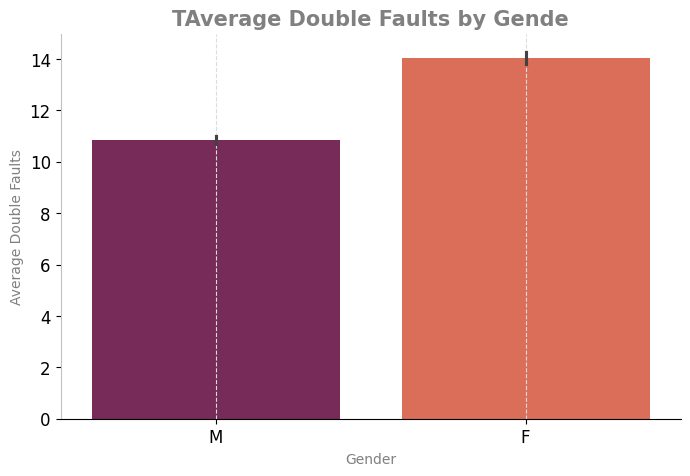

In [39]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='gender', y='double_faults', data=merged_df, palette='rocket')

ax.spines[["right","top"]].set_visible(False)
ax.spines[["left"]].set_color("#c2c2c2")

ax.set_title("TAverage Double Faults by Gende",
             weight="bold",
             color="grey",
             fontsize=15)

ax.tick_params(axis="x", labelsize="large")
ax.tick_params(axis="y", labelsize="large")

ax.set_xlabel("Gender", fontsize=10, color="grey")
ax.set_ylabel("Average Double Faults", fontsize=10, color="grey")

ax.grid(axis="x", linestyle="dashed", color="gainsboro")

plt.savefig("../outputs/figures/avgDoubleFaults.png", dpi=300)
plt.show()